27/1/25 - 5/2/25
Plan:
- A very short follow-on and note-like piece to show how to stop model training and prevent overfitting by using early stopping code in PyTorch during model training
- Probably should mention this is a bit like a QSAR/QSPR workflow piece?

Likely steps:
- simply add early stopping code in the model training part (early stopping function in training loop way)
    - add an early stopping function/class and test it *in situ* first, then perhaps show code only as a note post?
- ?to add more data... (hmm... will see)


---following is the DNN on ADRs post---

*The notebook from [this repository](https://github.com/jhylin/Adverse_drug_reactions) uses a venv created by [using uv](https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment) with [a kernel set up this way](https://docs.astral.sh/uv/guides/integration/jupyter/#using-jupyter-from-vs-code).*

*Some of the code blocks have been folded to keep the post length a bit more manageable - click on the code links to see full code (only applies to the HTML version, not the Jupyter notebook version).*

<br>

##### **Import libraries**

In [1]:
#| code-fold: true
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import datamol as dm
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import useful_rdkit_utils as uru
import sys
from matplotlib import pyplot as plt
print(f"Pandas version used: {pd.__version__}")
print(f"PyTorch version used: {torch.__version__}")
print(f"NumPy version used: {np.__version__}")
print(f"RDKit version used: {rdkit.__version__}")
print(f"Python version used: {sys.version}")

Pandas version used: 2.2.3
PyTorch version used: 2.2.2
NumPy version used: 1.26.4
RDKit version used: 2024.03.6
Python version used: 3.12.7 (main, Oct 16 2024, 09:10:10) [Clang 18.1.8 ]


<br>

##### **Import adverse drug reactions (ADRs) data**

This is an extremely small set of data compiled manually (by me) via references stated in the dataframe. For details about what and how the data are collected, I've prepared a separate post as a [data note](https://jhylin.github.io/Data_in_life_blog/posts/22_Simple_dnn_adrs/1_ADR_data.html) to explain key things about the data. It may not lead to a very significant result but it is done as an example of what an early or basic deep neural network (DNN) model may look like. Ideally there should be more training data and also more features added or used. I've hypothetically set the goal of this introductory piece to predict therapeutic drug classes from ADRs, molecular fingerprints and cytochrome P450 substrate strengths, but this won't be achieved in this initial post (yet).

In [2]:
data = pd.read_csv("All_CYP3A4_substrates")
print(data.shape)
data.head(3)

(27, 8)


,generic_drug_name,notes,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,first_ref,second_ref,date_checked
0,carbamazepine,NaN,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som...",drugs.com,nzf,211024
1,eliglustat,NaN,strong,metabolic_agents,"diarrhea^^, oropharyngeal_pain^^, arthralgia^^...",drugs.com,emc,151124
2,flibanserin,NaN,strong,CNS_agents,"dizziness^^, somnolence^^, sedation^, fatigue^...",drugs.com,Drugs@FDA,161124


For drug with astericks marked in "notes" column, see data notes under "Exceptions or notes for ADRs" section in [separate post](https://jhylin.github.io/Data_in_life_blog/posts/22_Simple_dnn_adrs/1_ADR_data.html).

I'm dropping some of the columns that are not going to be used later.

In [3]:
#| code-fold: true
df = data.drop([
    "notes",
    "first_ref", 
    "second_ref", 
    "date_checked"
    ], axis=1)
df.head(3)

,generic_drug_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions
0,carbamazepine,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som..."
1,eliglustat,strong,metabolic_agents,"diarrhea^^, oropharyngeal_pain^^, arthralgia^^..."
2,flibanserin,strong,CNS_agents,"dizziness^^, somnolence^^, sedation^, fatigue^..."


<br>

##### **Import SMILES data from ChEMBL**

Before extracting data from ChEMBL, I'm getting a list of drug names in capital letters ready first which can be fed into chembl_downloader with my old cyp_drugs.py to retrieve the SMILES of these drugs.

In [4]:
#| code-fold: true
string = df["generic_drug_name"].tolist()
# Convert list of drugs into multiple strings of drug names
drugs = f"'{"','".join(string)}'"
# Convert from lower case to upper case
for letter in drugs:
    if letter.islower():
        drugs = drugs.replace(letter, letter.upper())
print(drugs)

'CARBAMAZEPINE','ELIGLUSTAT','FLIBANSERIN','IMATINIB','IBRUTINIB','NERATINIB','ESOMEPRAZOLE','OMEPRAZOLE','IVACAFTOR','NALOXEGOL','OXYCODONE','SIROLIMUS','TERFENADINE','DIAZEPAM','HYDROCORTISONE','LANSOPRAZOLE','PANTOPRAZOLE','LERCANIDIPINE','NALDEMEDINE','NELFINAVIR','TELAPREVIR','ONDANSETRON','QUININE','RIBOCICLIB','SUVOREXANT','TELITHROMYCIN','TEMSIROLIMUS'


In [5]:
#| code-fold: true
# Get SMILES for each drug (via copying-and-pasting the previous cell output - attempted various ways to feed the string
# directly into cyp_drugs.py, current way seems to be the most straightforward one...)
from cyp_drugs import chembl_drugs
# Using ChEMBL version 34
df_3a4 = chembl_drugs(
    'CARBAMAZEPINE','ELIGLUSTAT','FLIBANSERIN','IMATINIB','IBRUTINIB','NERATINIB','ESOMEPRAZOLE','OMEPRAZOLE','IVACAFTOR','NALOXEGOL','OXYCODONE','SIROLIMUS','TERFENADINE','DIAZEPAM','HYDROCORTISONE','LANSOPRAZOLE','PANTOPRAZOLE','LERCANIDIPINE','NALDEMEDINE','NELFINAVIR','TELAPREVIR','ONDANSETRON','QUININE','RIBOCICLIB','SUVOREXANT','TELITHROMYCIN','TEMSIROLIMUS', 
    #file_name="All_cyp3a4_smiles"
    )
print(df_3a4.shape)
df_3a4.head(3)

## Note: latest ChEMBL version 35 (as from 1st Dec 2024) seems to be taking a long time to load (no output after ~7min), 
## both versions 33 & 34 are ok with outputs loading within a few secs

(27, 4)


,chembl_id,pref_name,max_phase,canonical_smiles
0,CHEMBL108,CARBAMAZEPINE,4,NC(=O)N1c2ccccc2C=Cc2ccccc21
1,CHEMBL12,DIAZEPAM,4,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
2,CHEMBL2110588,ELIGLUSTAT,4,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...


<br>

##### **Merge dataframes**

Next, I'm renaming the drug name column and merging the two dataframes together where one contains the ADRs and the other one contains the SMILES. I'm also making sure all drug names are in upper case for both dataframes so they can merge properly.

In [6]:
#| code-fold: true
# Rename column & change lower to uppercase
df = df.rename(columns={"generic_drug_name": "pref_name"})
df["pref_name"] = df["pref_name"].str.upper()
# Merge df & df_3a4 
df = df.merge(df_3a4, how="left", on="pref_name")
df.head(3)

,pref_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,chembl_id,max_phase,canonical_smiles
0,CARBAMAZEPINE,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som...",CHEMBL108,4,NC(=O)N1c2ccccc2C=Cc2ccccc21
1,ELIGLUSTAT,strong,metabolic_agents,"diarrhea^^, oropharyngeal_pain^^, arthralgia^^...",CHEMBL2110588,4,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...
2,FLIBANSERIN,strong,CNS_agents,"dizziness^^, somnolence^^, sedation^, fatigue^...",CHEMBL231068,4,O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1


<br>

##### **Parse SMILES**

Then I'm parsing the canonical SMILES through my old script to generate these small molecules as RDKit molecules and standardised SMILES, making sure these SMILES are parsable.

In [7]:
#| code-fold: true

# Using my previous code to preprocess small mols
# disable rdkit messages
dm.disable_rdkit_log()

#  The following function code were adapted from datamol.io
def preprocess(row):

    """
    Function to preprocess, fix, standardise, sanitise compounds 
    and then generate various molecular representations based on these molecules.
    Can be utilised as df.apply(preprocess, axis=1).

    :param smiles_column: SMILES column name (needs to be names as "canonical_smiles") 
    derived from ChEMBL database (or any other sources) via an input dataframe
    :param mol: RDKit molecules
    :return: preprocessed RDKit molecules, standardised SMILES, SELFIES, 
    InChI and InChI keys added as separate columns in the dataframe
    """

    # smiles_column = strings object
    smiles_column = "canonical_smiles"
    # Convert each compound into a RDKit molecule in the smiles column
    mol = dm.to_mol(row[smiles_column], ordered=True)
    # Fix common errors in the molecules
    mol = dm.fix_mol(mol)
    # Sanitise the molecules 
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    # Standardise the molecules
    mol = dm.standardize_mol(
        mol,
        # Switch on to disconnect metal ions
        disconnect_metals=True,
        normalize=True,
        reionize=True,
        # Switch on "uncharge" to neutralise charges
        uncharge=True,
        # Taking care of stereochemistries of compounds
        # Note: this uses the older approach of "AssignStereochemistry()" from RDKit
        # https://github.com/datamol-io/datamol/blob/main/datamol/mol.py#L488
        stereo=True,
    )

    # Adding following rows of different molecular representations 
    row["rdkit_mol"] = dm.to_mol(mol)
    row["standard_smiles"] = dm.standardize_smiles(str(dm.to_smiles(mol)))
    #row["selfies"] = dm.to_selfies(mol)
    #row["inchi"] = dm.to_inchi(mol)
    #row["inchikey"] = dm.to_inchikey(mol)
    return row

df_p3a4 = df.apply(preprocess, axis = 1)
print(df_p3a4.shape)
df_p3a4.head(3)

(27, 9)


,pref_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,chembl_id,max_phase,canonical_smiles,rdkit_mol,standard_smiles
0,CARBAMAZEPINE,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som...",CHEMBL108,4,NC(=O)N1c2ccccc2C=Cc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x14228f840>,NC(=O)N1c2ccccc2C=Cc2ccccc21
1,ELIGLUSTAT,strong,metabolic_agents,"diarrhea^^, oropharyngeal_pain^^, arthralgia^^...",CHEMBL2110588,4,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...,<rdkit.Chem.rdchem.Mol object at 0x14228f920>,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...
2,FLIBANSERIN,strong,CNS_agents,"dizziness^^, somnolence^^, sedation^, fatigue^...",CHEMBL231068,4,O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1,<rdkit.Chem.rdchem.Mol object at 0x14228f990>,O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1


<br>

##### **Split data**

Random splits usually lead to overly optimistic models, where testing molecules are too similar to traininig molecules leading to many problems. This is further discussed in two other blog posts that I've found useful - [post by Greg Landrum](https://greglandrum.github.io/rdkit-blog/posts/2024-05-31-scaffold-splits-and-murcko-scaffolds1.html) and [post by Pat Walters](https://practicalcheminformatics.blogspot.com/2024/11/some-thoughts-on-splitting-chemical.html).

Here I'm trying out Pat's [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils)' GroupKFoldShuffle code (code originated from [this thread](https://github.com/scikit-learn/scikit-learn/issues/20520)) to split data (Butina clustering/splits). To do this, it requires SMILES to generate molecular fingerprints which will be used in the training and testing sets (potentially for future posts and in real-life cases, more things can be done with the SMILES or other molecular representations for machine learning, but to keep this post easy-to-read, I'll stick with only generating the Morgan fingerprints for now). 

In [8]:
#| code-fold: true
# Generate numpy arrays containing the fingerprints 
df_p3a4['fp'] = df_p3a4.rdkit_mol.apply(rdFingerprintGenerator.GetMorganGenerator().GetCountFingerprintAsNumPy)

# Get Butina cluster labels
df_p3a4["butina_cluster"] = uru.get_butina_clusters(df_p3a4.standard_smiles)

# Set up a GroupKFoldShuffle object
group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)

# Using cross-validation/doing data split
## X = np.stack(df_s3a4.fp), y = df.adverse_drug_reactions, group labels = df_s3a4.butina_cluster
for train, test in group_kfold_shuffle.split(np.stack(df_p3a4.fp), df.adverse_drug_reactions, df_p3a4.butina_cluster):
    print(len(train),len(test))

22 5
23 4
23 4
17 10
23 4


<br>

##### **Locate training and testing sets after data split**

While trying to figure out how to locate training and testing sets after the data split, I've gone into a mini rabbit hole myself (a self-confusing session but gladly it clears up when my thought process goes further...). For example, some of the ways I've planned to try: create a dictionary as {index: butina label} first - butina cluster labels vs. index e.g. df_s3a4["butina_cluster"], or maybe can directly convert from NumPy array to tensor - will need to locate drugs via indices first to specify training and testing sets, e.g. torch_train = torch.from_numpy(train) or torch_test = torch.from_numpy(test). It is actually simpler than this, which is to use pd.DataFrame.iloc() as shown below.

In [9]:
# Training set indices
train

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 24, 25, 26])

In [10]:
# What df_p3a4 now looks like after data split - with "fp" and "butina_cluster" columns added
df_p3a4.head(1)

,pref_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,chembl_id,max_phase,canonical_smiles,rdkit_mol,standard_smiles,fp,butina_cluster
0,CARBAMAZEPINE,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som...",CHEMBL108,4,NC(=O)N1c2ccccc2C=Cc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x14228f840>,NC(=O)N1c2ccccc2C=Cc2ccccc21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20


In [11]:
# Convert indices into list
train_set = train.tolist()
# Locate drugs and drug info via pd.DataFrame.iloc
df_train = df_p3a4.iloc[train_set]
print(df_train.shape)
df_train.head(2)

(23, 11)


,pref_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,chembl_id,max_phase,canonical_smiles,rdkit_mol,standard_smiles,fp,butina_cluster
0,CARBAMAZEPINE,strong,antiepileptics,"constipation^^, leucopenia^^, dizziness^^, som...",CHEMBL108,4,NC(=O)N1c2ccccc2C=Cc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x14228f840>,NC(=O)N1c2ccccc2C=Cc2ccccc21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20
4,IBRUTINIB,strong,tyrosine_kinase_inhibitor,"hypertension^^, atrial_fibrillation^^, sinus_t...",CHEMBL1873475,4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,<rdkit.Chem.rdchem.Mol object at 0x14228f680>,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16


In [12]:
# Testing set indices
test

array([ 1,  2,  3, 23])

In [13]:
test_set = test.tolist()
df_test = df_p3a4.iloc[test_set]
print(df_test.shape)
df_test.head(2)

(4, 11)


,pref_name,cyp_strength_of_evidence,drug_class,adverse_drug_reactions,chembl_id,max_phase,canonical_smiles,rdkit_mol,standard_smiles,fp,butina_cluster
1,ELIGLUSTAT,strong,metabolic_agents,"diarrhea^^, oropharyngeal_pain^^, arthralgia^^...",CHEMBL2110588,4,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...,<rdkit.Chem.rdchem.Mol object at 0x14228f920>,CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1...,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19
2,FLIBANSERIN,strong,CNS_agents,"dizziness^^, somnolence^^, sedation^, fatigue^...",CHEMBL231068,4,O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1,<rdkit.Chem.rdchem.Mol object at 0x14228f990>,O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18


<br>

##### **Set up training and testing sets for X and y variables**

This part involves converting X (features) and y (target) variables into either one-hot encodings or vector embeddings, since I'll be dealing with categories/words/ADRs and not numbers, and also to split each X and y variables into training and testing sets. At the very beginning, I've thought about using scikit_learn's train_test_split(), but then realised that I should not need to do this as it's already been done in the previous step (obviously I'm confusing myself again...). Essentially, this step can be integrated with the one-hot encoding and vector embeddings part as shown below.

There are three coding issues that have triggered warning messages when I'm trying to figure out how to convert CYP strengths into one-hot encodings:

1. A useful [thread](https://github.com/pandas-dev/pandas/issues/57734) has helped me to solve the downcasting issue in pd.DataFrame.replace() when trying to do one-hot encoding to replace the CYP strengths for each drug

2. A Pandas setting-with-copy warning shows if using df["column_name"]:

> A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead

The solution is to enable the copy-on-write globally (as commented in the code below; from [Pandas reference](https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#copy-on-write-cow)).

3. PyTorch user warning appers if using df_train["cyp_strength_of_evidence"].values, as this leads to non-writable tensors with a warning like this:

> UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)

One of the solutions is to add copy() e.g. col_encoded = one_hot(torch.from_numpy(df["column_name"].values.copy()) % total_numbers_in_column) or alternatively, convert column into numpy array first, then make the numpy array writeable (which is what I've used in the code below).

In [14]:
#| code-fold: true
## X_train
# 1. Convert "cyp_strength_of_evidence" column into one-hot encoding
# Enable copy-on-write globally to remove the warning
pd.options.mode.copy_on_write = True

# Replace CYP strength as numbers
with pd.option_context('future.no_silent_downcasting', True):
   df_train["cyp_strength_of_evidence"] = df_train["cyp_strength_of_evidence"].replace({"strong": 1, "mod": 2}).infer_objects()
   df_test["cyp_strength_of_evidence"] = df_test["cyp_strength_of_evidence"].replace({"strong": 1, "mod": 2}).infer_objects()

# Get total number of CYP strengths in df
total_cyp_str_train = len(set(df_train["cyp_strength_of_evidence"]))

# Convert column into numpy array first, then make the numpy array writeable
cyp_array_train = df_train["cyp_strength_of_evidence"].to_numpy()
cyp_array_train.flags.writeable = True
cyp_str_train_t = one_hot(torch.from_numpy(cyp_array_train) % total_cyp_str_train)
cyp_str_train_t

tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

Without going into too much details about vector embeddings (as there are a lot of useful learning materials about it online and in texts), here's roughly how I understand embeddings while working on this post. Embeddings are real-valued dense vectors that are normally in multi-dimensional arrays and they can represent and catch the context of a word or sentence, the semantic similarity and especially the relation of each word with other words in a corpus of texts. They roughly form the basis of natural language processing and also contribute to how large language models are built... in a very simplified sense, but obviously this can get complex if we want the models to do more. Here, I'm trying something experimental so I'm going to convert each ADR for each drug into embeddings.

In [15]:
#| code-fold: true
# 2. Convert "adverse_drug_reactions" column into embeddings
## see separate scripts used previously e.g. words_tensors.py 
## or Tensors_for_adrs_interactive.py to show step-by-step conversions from words to tensors

# Save all ADRs from common ADRs column as a list (joining every row of ADRs in place only)
adr_str_train = df_train["adverse_drug_reactions"].tolist()
# Join separate rows of strings into one complete string
adr_string_train = ",".join(adr_str_train)
# Converting all ADRs into Torch tensors using words_tensors.py
from words_tensors import words_tensors
adr_train_t = words_tensors(adr_string_train)
adr_train_t

tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        ...,
        [ 1.2051, -0.0683],
        [-0.9326,  0.0741],
        [-0.4875, -0.4971]], grad_fn=<EmbeddingBackward0>)

When trying to convert the "fp" column into tensors, there is one coding issue I've found relating to the data split step earlier. Each time the notebook is re-run with the kernel refreshed, the data split will lead to different proportions of training and testing sets due to the "shuffle = True", which subsequently leads to different training and testing set arrays. One of the ways to circumvent this is to turn off the shuffle but this is not ideal for model training. So an alternative way that I've tried is to use ndarray.size (which is the product of elements in ndarray.shape, equivalent to multiplying the numbers of rows and columns), and divide the row of the intended tensor shape by 2 as I'm trying to reshape training arrays so they're all in 2 columns in order for [torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html#torch-cat) to work later.

In [16]:
#| code-fold: true
# 3. Convert "fp" column into tensors
# Stack numpy arrays in fingerprint column
fp_train_array = np.stack(df_train["fp"])
# Convert numpy array data type from uint32 to int32
fp_train_array = fp_train_array.astype("int32")
# Create tensors from array
fp_train_t = torch.from_numpy(fp_train_array)
# Reshape tensors
fp_train_t = torch.reshape(fp_train_t, (int(fp_train_array.size/2), 2))
fp_train_t.shape # tensor.ndim to check tensor dimensions

torch.Size([23552, 2])

In [17]:
adr_train_t.shape

torch.Size([725, 2])

In [18]:
cyp_str_train_t.shape

torch.Size([23, 2])

In [19]:
# Concatenate adr tensors, fingerprint tensors and cyp strength tensors as X_train
X_train = torch.cat([adr_train_t, fp_train_t, cyp_str_train_t], 0).float()
X_train

tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        ...,
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000]], grad_fn=<CatBackward0>)

X_test is being set up similarly as shown below.

In [20]:
#| code-fold: true
## X_test
# 1. Convert "cyp_strength_of_evidence" into one-hot encodings
total_cyp_str_test = len(set(df_test["cyp_strength_of_evidence"]))
array_test = df_test["cyp_strength_of_evidence"].to_numpy()
array_test.flags.writeable = True
cyp_str_test_t = one_hot(torch.from_numpy(array_test) % total_cyp_str_test)

# 2. Convert "adverse_drug_reactions" column into embeddings
adr_str_test = df_test["adverse_drug_reactions"].tolist()
adr_string_test = ",".join(adr_str_test)
adr_test_t = words_tensors(adr_string_test)

# 3. Convert "fp" column into tensors
fp_test_array = np.stack(df_test["fp"])
fp_test_array = fp_test_array.astype("int32")
fp_test_t = torch.from_numpy(fp_test_array)
fp_test_t = torch.reshape(fp_test_t, (int(fp_test_array.size/2),2))

# Concatenate adr tensors, drug class tensors and cyp strength tensors as X_test
X_test = torch.cat([cyp_str_test_t, adr_test_t, fp_test_t], 0).float()
X_test

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 0.],
        [0., 0.],
        [1., 0.]], grad_fn=<CatBackward0>)

This is followed by setting up y_train.

In [21]:
#| code-fold: true
## y_train
# Use drug_class column as target
# Convert "drug_class" column into embeddings 
# total number of drug classes in df = 20 - len(set(df["drug_class"])) - using embeddings instead of one-hot
dc_str_train = df_train["drug_class"].tolist()
dc_string_train = ",".join(dc_str_train)
y_train = words_tensors(dc_string_train)
y_train

tensor([[ 0.3232, -0.3847]], grad_fn=<EmbeddingBackward0>)

Lastly, y_test is being specified.

In [22]:
#| code-fold: true
## y_test
# Convert "drug_class" column into embeddings 
dc_str_test = df_test["drug_class"].tolist()
dc_string_test = ",".join(dc_str_test)
y_test = words_tensors(dc_string_test)
y_test

tensor([[-0.2699,  0.4822]], grad_fn=<EmbeddingBackward0>)

<br>

##### **Input preprocessing pipeline using PyTorch Dataset and DataLoader**

There is a size-mismatch-between-tensors warning when I'm trying to use PyTorch's TensorDataset(). I've found out that to use the data loader and tensor dataset, the first dimension of all tensors needs to be the same. Initially, they're not, where X_train.shape = [24313, 2], y_train.shape = [1, 2]. Eventually I've settled on two ways that can help with this: 

- use tensor.unsqueeze(dim = 1) or 

- use tensor[None] which'll insert a new dimension at the beginning, then it becomes: X_train.shape = [1, 24313, 2], y_train.shape = [1, 1, 2]

In [23]:
X_train[None].shape

torch.Size([1, 24300, 2])

In [24]:
X_train.shape

torch.Size([24300, 2])

In [25]:
y_train[None].shape

torch.Size([1, 1, 2])

In [26]:
y_train.shape

torch.Size([1, 2])

In [27]:
# Create a PyTorch dataset on training data set
train_data = TensorDataset(X_train[None], y_train[None])
# Sets a seed number to generate random numbers
torch.manual_seed(1)
batch_size = 1

# Create a dataset loader
train_dl = DataLoader(train_data, batch_size, shuffle = True)

In [28]:
# Create another PyTorch dataset on testing data set
test_data = TensorDataset(X_test[None], y_test[None])
torch.manual_seed(1)
batch_size = 1
test_dl = DataLoader(test_data, batch_size, shuffle=True)

<br>

##### **Set up a simple DNN regression model** 

I'm only going to use a very simple two-layer DNN model to match the tiny dataset used here. There are many other types of neural network layers or bits and pieces that can be used to suit the goals and purposes of the dataset used. This [reference link](https://pytorch.org/docs/stable/nn.html) shows different types of neural network layers that can be used in PyTorch.

Below are some short notes regarding a neural network (NN) model:
 
- goal of the model is to minimise loss function L(W) (where W = weight) to get the optimal model weights

- matrix with W (for hidden layer) connects input to hidden layer; matrix with W (for outer layer) connects hidden to output layer

- *Input layer* -> activation function of hidden layer -> *hidden layer* -> activation function of output layer -> *output layer* (a very-simplified flow diagram to show how the layers get connected to each other)


About backpropagation for loss function:

- backpropagation is a computationally efficient way to calculate partial derivatives of loss function to update weights in multi-layer NNs

- it's based on calculus chain rule to compute derivatives of mathematical functions (automatic differentiation)

- matrix-vector multiplications in backpropagation are computationally more efficient to calculate than matrix-matrix multiplications e.g. forward propagation

Note: there are also [other types of activation functions available](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions) to use in PyTorch.

In [29]:
#| code-fold: true
# note: this is a very simple two-layer NN model only

# Set up hidden units between two connected layers - one layer with 6 hidden units and the other with 3 hidden units
hidden_units = [6, 3]
# Input size same as number of columns in X_train
input_size = X_train.shape[1]
# Initiate NN layers as a list
all_layers = []

## Specify how the input, hidden and output layers are going to be connected
# For each hidden unit within the hidden units specified above:
for h_unit in hidden_units:
    # specify sizes of input sample (input size = X_train col size) & output sample (hidden units) in each layer
    # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    layer = nn.Linear(input_size, h_unit)
    # add each layer
    all_layers.append(layer)
    # add activation function (trying rectified linear unit) for next layer
    all_layers.append(nn.ReLU())
    # for the next layer to be added, the input size will be the same size as the hidden unit
    input_size = h_unit

# Specify the last layer (where input_feature = hidden_units[-1] = 3)
all_layers.append(nn.Linear(hidden_units[-1], 1))

# Set up a container that'll connect all layers in the specified sequence in the model
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

<br>

##### **Train model**

This part is mainly about defining the loss function when training the model with the training data, and optimising model by using a stochastic gradient descent. One key thing I've gathered from trying to learn about deep learning is that we're aiming for global minima and not local minima (e.g. if learning rate is too small, this may end up with local minima; if learning rate is too large, it may end up over-estimating the global minima). I've also encountered the PyTorch padding method to make sure the input and target tensors are of the same size, otherwise the model will run into matrix broadcasting issue (which will likely influence the results). The training loss appears to have converged when the epoch runs reach 100 and/or after (note this may vary due to shuffle data sampling)... (I also think my data size is way too small to show a clear contrast in training loss convergence).

References for: [nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) - measures mean squared error between X and y, and [nn.functional.pad()](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad) - pads tensor (increase tensor size) 

Obtaining training loss via model training:

In [30]:
#| code-fold: true
# Set up loss function
loss_f = nn.MSELoss()
# Set up stochastic gradient descent optimiser to optimise model (minimise loss) during training 
# lr = learning rate - default: 0.049787 (1*e^-3)
optim = torch.optim.SGD(model.parameters(), lr=0.005)
# Set training epochs (epoch: each cycle of training or passing through the training set)
num_epochs = 200
# Set the log output to show training loss - for every 20 epochs
log_epochs = 20
torch.manual_seed(1)
# Create empty lists to save training loss (for training and testing/validation sets)
train_epoch_loss = []
test_epoch_loss = []

#  Predict via training X_batch & obtain train loss via loss function from X_batch & y_batch
for epoch in range(num_epochs):
    train_loss = 0
    for X_batch, y_batch in train_dl:
        # Make predictions
        predict = model(X_batch)[:, 0]
        # Make input tensors the same size as y_batch tensors
        predict_pad = F.pad(predict[None], pad=(1, 0, 0, 0))
        # Calculate training loss
        loss = loss_f(predict_pad, y_batch)
        # Calculate gradients (backpropagations)
        loss.backward(retain_graph=True)
        # Update parameters using gradients
        optim.step()
        # Reset gradients back to zero
        optim.zero_grad()
        train_loss += loss.item()
    
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {train_loss/len(train_dl):.4f}")

    train_epoch_loss.append(train_loss)

Epoch 0 Loss 0.3051
Epoch 20 Loss 0.2239
Epoch 40 Loss 0.1769
Epoch 60 Loss 0.1435
Epoch 80 Loss 0.1181
Epoch 100 Loss 0.0994
Epoch 120 Loss 0.0859
Epoch 140 Loss 0.0759
Epoch 160 Loss 0.0688
Epoch 180 Loss 0.0637


Obtaining test or validation loss:

In [ ]:
## Early stopping version 2
# I think this one focusses more on the test loss trend (rather than the gap between train loss and test loss)
# using another parameter instead: min_test_loss (instead of early_stop) in the __init__ function
# no need to use __call__ function as this is used inside the training loop for the test/validation set

class Early_stopping:
    def __init__(self, epochs_to_wait = 1, delta = 0):
        self.epochs_to_wait = epochs_to_wait
        self.delta = delta
        self.min_test_loss = np.inf
        self.counter = 0
    
    def early_stop(self, test_loss):
        if test_loss < self.min_test_loss:
            self.min_test_loss = test_loss
            self.counter = 0
        elif test_loss > (self.min_test_loss + self.delta):
            self.counter += 1
            if self.counter >= self.epochs_to_wait:
                return True
        return False
    
early_stopper = Early_stopping(epochs_to_wait = 2, delta = 0)

In [ ]:
#| code-fold: true
# Predict via testing X_batch & obtain test loss 
for epoch in range(num_epochs):
    test_loss = 0
    for X_batch, y_batch in test_dl:
        # Make predictions
        predict_test = model(X_batch)[:, 0]
        # Make input tensors the same size as y_batch tensors
        predict_pad_test = F.pad(predict_test[None], pad=(1, 0, 0, 0))
        # Calculate training loss
        loss = loss_f(predict_pad_test, y_batch)
        # Calculate gradients (backpropagations)
        loss.backward(retain_graph=True)
        # Update parameters using gradients
        optim.step()
        # Reset gradients back to zero
        optim.zero_grad()
        test_loss += loss.item()

    # Using early stopping (version 2)
    if early_stopper.early_stop(test_loss):
        break
    
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {test_loss/len(test_dl):.4f}")

    test_epoch_loss.append(test_loss)

Epoch 0 Loss 0.2420
Epoch 20 Loss 0.1624
Epoch 40 Loss 0.1144
Epoch 60 Loss 0.0849
Epoch 80 Loss 0.0666
Epoch 100 Loss 0.0553
Epoch 120 Loss 0.0482
Epoch 140 Loss 0.0438
Epoch 160 Loss 0.0410
Epoch 180 Loss 0.0392


In [33]:
# An early stopping class with different funtions (call the function in the model training loop) 
# a few different versions in code (depending on use cases and needs)

# ## Version 1
# class EarlyStopping:
#     def __init__(self, epochs_to_wait = 1, delta = 0):
#         self.epochs_to_wait = epochs_to_wait
#         self.delta = delta
#         self.early_stop = False
#         self.counter = 0

#     def __call__(self, test_loss, train_loss):
#         if (test_loss - train_loss) > self.delta:
#             self.counter += 1
#             if self.counter > self.epochs_to_wait:
#                 self.early_stop = True

# early_stopper = EarlyStopping(epochs_to_wait = 2, delta = 0)

# for i in range(len(train_epoch_loss)):
#     early_stopper(train_epoch_loss[i], test_epoch_loss[i])
#     print(f"train loss: {train_epoch_loss[i]} test loss: {test_epoch_loss[i]}")
#     if early_stopper.early_stop:
#         print("Early stop at epoch:", i)
#         break


# can alter delta to specify how big the difference is between train & test losses (the gap between them)
# epochs_to_wait can be altered too to specify at least how many epochs need to pass before using early stopping
# due to the small-sized dataset being used here, the delta needs to be at 0 (since the losses are very small as well...), 
# otherwise there won't be an early stop at all, the training epochs will just keep rolling...
# other dataset should bring more interesting results!
# again butina split with shuffling will alter results on each refreshed run

<br>

##### **Evaluate model**

Showing train and test losses over training epochs in a plot:

<function matplotlib.pyplot.show(close=None, block=None)>

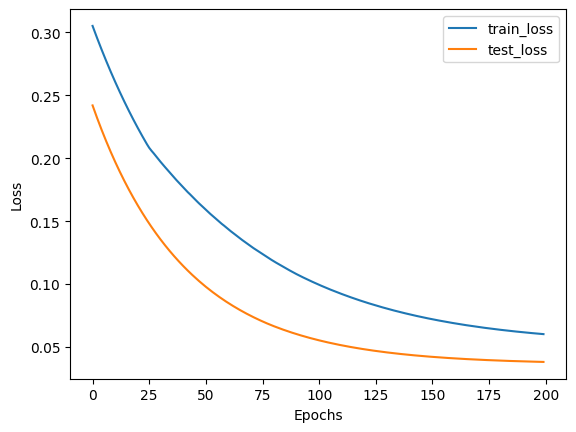

In [34]:
#| code-fold: true
plt.plot(train_epoch_loss, label="train_loss")
plt.plot(test_epoch_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

At the moment, when this notebook is re-run on a refreshed kernel, this leads to a different train and test split each time, and also leading to a different train and test (validation) loss each time. There may be two types of scenarios shown in the plot above where:

- test loss is higher than train loss (overfitting) - showing the model may be way too simplified and is likely under-trained
- train loss is higher than test loss (underfitting) - showing that the model may not have been trained well, and is unable to learn the features in the training data and apply them to the test data

When there are actually more training data available with also other hyperparameters fine tuned, it may be possible to see another scenario where both test loss and train loss are very similar in trend, meaning the model is being trained well and able to generalise the training to the unseen data. 

To mitigate overfitting: 

- firstly there should be more training data than what I've had here

- use L1 or L2 regularisation to minimise model complexity by adding penalities to large weights

- use early stopping during model training to stop training the model when test loss is becoming higher than the train loss

- use [torch.nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to randomly drop out some of the neurons to ensure the exisiting neurons will learn features without being too reliant on other neighbouring neurons in the network

- ***I'll try the early stopping or drop out method in future posts since current post is relatively long already...***

To overcome underfitting:

- increase training epochs
- minimise regularisation
- consider building a more complex or deeper neural network model

I'm trying to keep this post simple so have only used mean squared error (MSE) and mean absolute error (MAE) to evaluate the model which has made a prediction on the test set. The smaller the MSE, the less error the model has when making predictions. However this is not the only metric that will determine if a model is optimal for predictions, as I've also noticed that every time there's a different train and test split, the MAE and MSE values will vary too, so it appears that some splits will generate smaller MSE and other splits will lead to larger MSE.

In [35]:
#| code-fold: true
# torch.no_grad() - disable gradient calculations to reduce memory usage for inference (also like a decorator)
with torch.no_grad():
    predict_test = model(X_test.float())[:, 0]
    # Padding target tensor with set size of [(1, 2)] as input tensor size will vary 
    # when notebook is re-run each time due to butina split with sample shuffling
    # so need to pad the target tensor accordingly
    y_test_pad = F.pad(y_test, pad=(predict_test[None].shape[1] - y_test.shape[1], 0, 0, 0))
    loss_new = loss_f(predict_test[None], y_test_pad)
    print(f"MSE for test set: {loss_new.item():.4f}")
    print(f"MAE for test set: {nn.L1Loss()(predict_test[None], y_test_pad).item():.4f}")

MSE for test set: 0.0308
MAE for test set: 0.1545


<br>

##### **Save model**

One way to save the model is like below.

In [36]:
path = "adr_regressor.pt"
torch.save(model, path)
model_reload = torch.load(path)
model_reload.eval()

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

<br>

##### **Reload model**

The saved model is reloaded below with a check to make sure the reloaded version is the same as the saved version.

References for: [torch.max](https://pytorch.org/docs/stable/generated/torch.max.html#torch.max) and [torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html#torch-argmax)

In [37]:
pred_reload = model_reload(X_test)
y_test_rel_pad = F.pad(y_test, pad=(pred_reload[None].shape[1] - y_test.shape[1], 0, 0, 0))
correct = (torch.argmax(pred_reload, dim=1) == y_test_rel_pad).float()
accuracy = correct.mean()
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9995


<br>

A few things to consider in the end:

- I haven't done feature standardisation for X_train which is to centre X_train mean and divide by its standard deviation, code may be like this, X_train_normalised = (X_train - np.mean(X_train))/np.std(X_train) (if used on training data, need to apply this to testing data too)

- Training features are certainly too small, however, the main goal of this very first post is to get an overall idea of how to construct a baseline DNN regression model. There are lots of other things that can be done to the ADRs data e.g. adding more drug molecular features and properties. I have essentially only used the initial molecular fingerprints generated when doing the data split to add a bit of molecular aspect in the training dataset.

- I haven't taken into account the frequencies of words (e.g. same drug classes and same ADR terms across different drugs) in the training and testing data, however, the aim of this first piece of work is also not a semantic analysis in natural language processing so this might not be needed...

- There may be other PyTorch functions that I do not yet know about that will deal with small datasets e.g. perhaps [torch.sparse](https://pytorch.org/docs/stable/sparse.html) may be useful?... so this piece is certainly not the only way to do it, but one of the many ways to work with small data

<br>

##### **Acknowledgements**

I'm very thankful for the existence of these references, websites and reviewer below which have helped me understand (or scratch a small surface of) deep learning and also solve the coding issues mentioned in this post:

- [PyTorch forums](https://discuss.pytorch.org/)

- [Stack Overflow](https://stackoverflow.com/)

- Raschka, Sebastian, Yuxi (Hayden) Liu, and Vahid Mirjalili. 2022. Machine Learning with PyTorch and Scikit-Learn. Birmingham, UK: Packt Publishing. 

- [Noel O'Boyle](https://baoilleach.blogspot.com) for feedback on this post
